In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
import itertools
from IPython.display import display, HTML
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ins = BrainSpan()

# Prepare data

In [2]:
wigler_fam_info = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/Supplementary_Table_1.xlsx")
famID2Gender = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandGender"].values))
famID2VIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandVIQ"].values))
famID2NVIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandNVIQ"].values))

In [3]:
#Variants = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014RecProLGD.xlsx")
Variants = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProLGD.xlsx")
Variants = Variants[['familyId','vcfVariant','inChild','effectGene','effectType']]
Variants['gender'] = Variants.apply (lambda row: famID2Gender[row["familyId"]], axis=1)
Variants['VIQ'] = Variants.apply (lambda row: famID2VIQ[row["familyId"]], axis=1)
Variants['NVIQ'] = Variants.apply (lambda row: famID2NVIQ[row["familyId"]], axis=1)

In [4]:
Variants[Variants["effectGene"]=="KMT2E"]
Variants.loc[Variants["effectGene"]=="KMT2E", "effectGene"] = "MLL5" 

In [5]:
Variants = Variants[~Variants["effectGene"].isin(["ZC3H4"])]
Variants.shape

(389, 8)

In [6]:
AllGenes = set(Variants["effectGene"].values)
print(len(AllGenes))

351


In [7]:
Chrs = [x.split(":")[0] for x in Variants["vcfVariant"].values]
Genes = Variants["effectGene"].values
gene2chr = dict(zip(Genes, Chrs))

In [8]:
# Check same gene same proband
for gene in list(AllGenes):
    tmp = Variants[Variants["effectGene"] == gene]
    if len(set(tmp["familyId"])) != tmp.shape[0]:
        print(gene)
        display(tmp)

In [9]:
gene_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
gene_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
display(gene_exp_col.head(2))
display(gene_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
0,1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
1,2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
0,1,7062.0,ENSG00000000003,TSPAN6,7105.0
1,2,40735.0,ENSG00000000005,TNMD,64102.0


In [10]:
exon_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv")
exon_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv")
cds_dict = loaddict()
exon_exp_row["exon length"] = exon_exp_row["end"] - exon_exp_row["start"]
exon_exp_row["cds length"] = exon_exp_row.apply(lambda row: addcds(row, cds_dict), axis=1)
exon_exp_col["Period"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
exon_exp_col["Stage"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
exon_exp_col["Description"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
gene_exp_col["Period"] = gene_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
display(exon_exp_col.head(2))
display(exon_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,108


In [11]:
qn_gene_exp_recgenes = pd.read_csv("unifiedmodel/LGDGenes_exp_matrix.csv")
qn_exon_exp_recgenes = pd.read_csv("unifiedmodel/LGDExons_exp_matrix.csv")

In [12]:
exon_exp_row_recgenes = exon_exp_row[exon_exp_row["gene_symbol"].isin(AllGenes)]
exon_exp_row_recgenes["rel.exp"] = 0.0
exon_exp_row_recgenes["isLastExon"] = "F"
for i, row in exon_exp_row_recgenes.iterrows():
    gene, exonId = row["gene_symbol"], row["row_num"]
    gene_index = gene_exp_row[gene_exp_row["gene_symbol"]==gene]["row_num"].values[0]
    GeneExp = qn_gene_exp_recgenes[qn_gene_exp_recgenes["index"]==gene_index].values[0][1:]
    ExonExp = qn_exon_exp_recgenes[qn_exon_exp_recgenes["index"]==exonId].values[0][1:]
    #print(GeneExp[:5], ExonExp[:5])
    gene_amean, exon_amean = np.mean(GeneExp), np.mean(ExonExp)
    #gene_gmean, exon_gmean = sudogmean(GeneExp), sudogmean(ExonExp)
    exon_exp_row_recgenes.at[i, "rel.exp"] = exon_amean/gene_amean
    try:
        if gene != exon_exp_row_recgenes.at[i+1, "gene_symbol"]:
            exon_exp_row_recgenes.at[i, "isLastExon"] = "T"
    except:
        exon_exp_row_recgenes.at[i, "isLastExon"] = "T"
#exon_exp_row_recgenes = exon_exp_row_recgenes[exon_exp_row_recgenes["isLastExon"]=="F"]

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [13]:
exon_exp_row_recgenes["Chr"] = exon_exp_row_recgenes.apply(lambda row: gene2chr[row["gene_symbol"]], axis=1 )
exon_exp_row_recgenes.head()

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,rel.exp,isLastExon,Chr
1248,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,1.188120,F,7
1249,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,1.051193,F,7
1250,1251,1086943,ENSG00000005108,THSD7A,221981.0,11418696,11418907,211,211,1.168342,F,7
1251,1252,1086943,ENSG00000005108,THSD7A,221981.0,11419256,11419382,126,126,0.781333,F,7
1252,1253,1086943,ENSG00000005108,THSD7A,221981.0,11422147,11422243,96,96,1.098260,F,7


In [14]:
exon_exp_row_recgenes.to_csv("unifiedmodel/exon_exp_row_lgdgenes.csv", index=False)

In [15]:
exon_exp_row_recgenes_phyloP = pd.read_csv("unifiedmodel/exon_exp_row_lgdgenes.phyloP.csv")
exon_exp_row_recgenes_phyloP.set_index('row_num', inplace=True)
exon_exp_row_recgenes_phyloP.head(2)

,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,rel.exp,isLastExon,Chr,phyloP100way,phastCons100way
row_num,,,,,,,,,,,,,
1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,1.188120,F,7,0.793141,0.296318
1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,1.051193,F,7,5.170170,0.977000


In [16]:
Prenatal = Stages[:6]
Postnatal = Stages[6:]
PrenatalGeneCols = gene_exp_col[gene_exp_col["Period"].isin(Prenatal)]["column_num"].values
PostnatalGeneCols = gene_exp_col[gene_exp_col["Period"].isin(Postnatal)]["column_num"].values
PrenatalExonCols = exon_exp_col[exon_exp_col["Period"].isin(Prenatal)]["column_num"].values
PostnatalExonCols = exon_exp_col[exon_exp_col["Period"].isin(Postnatal)]["column_num"].values
print(PrenatalGeneCols[-1], PrenatalExonCols[-1])
#print(PrenatalGeneCols, PostnatalGeneCols)

237 237


In [17]:
domain_Jon = pd.read_csv("unifiedmodel/mut-domains.csv")
domain_Jon.set_index('KEY', inplace=True)
display(domain_Jon.head(2))
gerp_Jon = pd.read_csv("unifiedmodel/mut-gerp.csv")
gerp_Jon.set_index('KEY', inplace=True)
display(gerp_Jon.head(2))
#domain_Jon.loc["14075-1:3519050"]["DOM.TRUNC.FRAC"]
SSC_proband_metadata = pd.read_csv("/Users/jiayao/Work/BrainDisorders/JW/SSC_proband_metadata.csv")
DEVEL = "/Users/jiayao/Work/BrainDisorders/JW/Functional_Cluster_Gene_Lists/Cluster_DEVEL.txt"
NEURO = "/Users/jiayao/Work/BrainDisorders/JW/Functional_Cluster_Gene_Lists/Cluster_NEURO.txt"
neuronal = [l.strip() for l in open(NEURO, 'rt')]
develop  = [l.strip() for l in open(DEVEL, 'rt')]
print(len(neuronal), len(develop))

,DOM.TRUNC,DOM.KEPT,DOM.TRUNC.N,DOM.KEPT.N,DOM.TRUNC.FRAC
KEY,,,,,
11563-1:1222518,PF00858,NaN,1.0,0.0,1.0
14075-1:3519050,PF00053 PF07645 PF14670,NaN,3.0,0.0,1.0


,ensembl_exon_id,ensembl_transcript_id,ensembl_gene_id,chromosome_name,exon_chrom_start,exon_chrom_end,entrezgene,CONSERV
KEY,,,,,,,,
11563-1:1222518,ENSE00003620052,ENST00000338555,ENSG00000162572,1,1222489.0,1222679.0,6339.0,0.296541
14075-1:3519050,ENSE00001477190,ENST00000356575,ENSG00000162591,1,3519030.0,3519164.0,1953.0,1.888373


137 123


In [18]:
SSC_proband_metadata["famid"] = SSC_proband_metadata.apply(lambda row:row[0].split(".")[0], axis=1)
famid2age = dict(zip(SSC_proband_metadata["famid"].values, SSC_proband_metadata["age"].values))
SSC_proband_metadata.head()

,individual,family,age,sex,famid
0,11000.p1,quad,110,male,11000
1,11001.p1,trio,93,male,11001
2,11002.p1,quad,92,female,11002
3,11004.p1,quad,190,male,11004
4,11010.p1,quad,49,male,11010


In [19]:
math.pow(2,4)

16.0

In [20]:
def sudogmean(values):
    #values = [math.log2(x+1) for x in values]
    #gmean = np.mean(values)
    #return math.pow(2, gmean)
    values = [(x+1) for x in values]
    gmean = scipy.stats.mstats.gmean(values)
    return gmean-1
def searchExon(Gene, Chr, Pos, Ref, Alt, ExonExp, ExonRow, ExonCol):
    Pos, LenV = int(Pos), len(Ref)-len(Alt)
    ExonRow = ExonRow[ExonRow["gene_symbol"]==Gene]
    ith = 1
    for i, row in ExonRow.iterrows():
        row_num, start, end = row["row_num"],int(row["start"]),int(row["end"])
        #print(Pos, start, end)
        if Pos > start -3 and Pos < end + 3:
            if ith == ExonRow.shape[0]:
                return row_num, "Y"
            else:
                return row_num, "N"
        elif LenV > 0: # a delition may span a splice site
            if (Pos < start-3 and Pos + LenV > start ) or (Pos < end and Pos + LenV > end +3):
                if ith == ExonRow.shape[0]:
                    return row_num, "Y"
                else:
                    return row_num, "N"
        ith += 1
    return 0, "0"
def FunctionalGrouping(gene):
    if gene in neuronal:
        return 1
    elif gene in develop:
        return 2
    else:
        return 0
def DOM_TRUNC(X):
    if pd.isnull(X):
        return 0
    else:
        return 1

Variants["ExonID"] = 0
Variants["LastExon"] = "N"
Variants["GeneExp.amean"] = 0.0
Variants["GeneExp.gmean"] = 0.0
Variants["ExonExp.amean"] = 0.0
Variants["ExonExp.gmean"] = 0.0
Variants["GenePrenatalExp.amean"] = 0.0
Variants["GenePrenatalExp.gmean"] = 0.0
Variants["ExonPrenatalExp.amean"] = 0.0
Variants["ExonPrenatalExp.gmean"] = 0.0
Variants["GenePostnatalExp.amean"] = 0.0
Variants["GenePostnatalExp.gmean"] = 0.0
Variants["ExonPostnatalExp.amean"] = 0.0
Variants["ExonPostnatalExp.gmean"] = 0.0
Variants["phyloP100way"] = 0.0
for i, row in Variants.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    Variants.at[i, "Functional"] = FunctionalGrouping(gene)
    try:
        Variants.at[i, "Age"] = famid2age[str(famid)]
    except:
        Variants.at[i, "Age"] = 0
    try:
        GeneExp = qn_gene_exp_recgenes[qn_gene_exp_recgenes["index"]==
                                       gene_exp_row[gene_exp_row["gene_symbol"]==gene]["row_num"].values[0]].values[0][1:]
    except IndexError:
        print("gene not find", famid, gene)
    #print(np.mean(GeneExp), scipy.stats.mstats.gmean(GeneExp), sudogmean(GeneExp))
    GeneExpPre, GeneExpPost = GeneExp[1:238], GeneExp[238:]
    #GeneExp = [x for x in GeneExp if x != 0]
    #GeneExpPre = [x for x in GeneExpPre if x != 0]
    #GeneExpPre = [x for x in GeneExpPre if x != 0]
    gene_nmean, gene_gmean = np.mean(GeneExp), sudogmean(GeneExp)
    Variants.at[i, "GeneExp.amean"] = gene_nmean
    Variants.at[i, "GeneExp.gmean"] = gene_gmean
    exonId, LastExon = searchExon(gene, Chr, Pos, Ref, Alt, qn_exon_exp_recgenes, exon_exp_row, exon_exp_col)
    if len(Ref) == len(Alt):
        Variants.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos))
        Variants.at[i, "DOM.TRUNC.FRAC"] = domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["DOM.TRUNC.FRAC"]
        Variants.at[i, "DOM.TRUNC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["DOM.TRUNC"])
        Variants.at[i, "GERP"] = gerp_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["CONSERV"]
    else:
        Variants.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos)+1)
        Variants.at[i, "DOM.TRUNC.FRAC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["DOM.TRUNC.FRAC"])
        Variants.at[i, "DOM.TRUNC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["DOM.TRUNC"])
        Variants.at[i, "GERP"] = gerp_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["CONSERV"]
    if exonId != 0:
        Variants.at[i, "ExonID"] = exonId
        Variants.at[i, "LastExon"] = LastExon
        ExonExp = qn_exon_exp_recgenes[qn_exon_exp_recgenes["index"]==exonId].values[0][1:]
        ExonExpPre, ExonExpPost = ExonExp[1:238], ExonExp[238:]
        
        exon_nmean, exon_gmean = np.mean(ExonExp), sudogmean(ExonExp)
        Variants.at[i, "ExonExp.amean"] = exon_nmean
        Variants.at[i, "ExonExp.gmean"] = exon_gmean
        Variants.at[i, "Rel.exp.amean"] = exon_nmean/gene_nmean
        Variants.at[i, "Rel.exp.gmean"] = exon_gmean/gene_gmean
        
        Variants.at[i, "Rel.exp.prenatal"] = np.mean(ExonExpPre)/np.mean(GeneExpPre)
        Variants.at[i, "Rel.exp.postnatal"] = np.mean(ExonExpPost)/np.mean(GeneExpPost)
        try:
            Variants.at[i, "Prenatal.Bias"] = math.log2(np.mean(ExonExpPre)/np.mean(ExonExpPost))
        except ValueError:
            Variants.at[i, "Prenatal.Bias"] = 0
        #if LastExon == "N":
        Variants.at[i, "phyloP100way"] = exon_exp_row_recgenes_phyloP.loc[exonId]["phyloP100way"]
        Variants.at[i, "phastCons100way"] = exon_exp_row_recgenes_phyloP.loc[exonId]["phastCons100way"]
    else:
        print("exon not find", famid, gene)

exon not find 11208 C16orf13
gene not find 14575 CCDC171
exon not find 14575 CCDC171
gene not find 12563 CCPG1
exon not find 12563 CCPG1
gene not find 13548 GALNT18
exon not find 13548 GALNT18
gene not find 13861 KIR2DL2
exon not find 13861 KIR2DL2
gene not find 11145 KMT2A
exon not find 11145 KMT2A
gene not find 11148 KMT2C
exon not find 11148 KMT2C
gene not find 13590 MTHFS,ST20-MTHFS
exon not find 13590 MTHFS,ST20-MTHFS
gene not find 14473 NXPE4
exon not find 14473 NXPE4


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


gene not find 11925 SKIDA1
exon not find 11925 SKIDA1


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


gene not find 14644 UGT1A10,UGT1A8,UGT1A9,UGT1A4,UGT1A5,UGT1A6,UGT1A7,UGT1A1,UGT1A3
exon not find 14644 UGT1A10,UGT1A8,UGT1A9,UGT1A4,UGT1A5,UGT1A6,UGT1A7,UGT1A1,UGT1A3
gene not find 13913 ZNF853
exon not find 13913 ZNF853


In [21]:
tmpdf = Variants[np.isfinite(Variants['phyloP100way'])]
tmpdf = tmpdf[np.isfinite(tmpdf['NVIQ'])]

In [22]:
r, p = spearmanr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)
r, p = pearsonr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)

-0.16035774720792725 0.0015295285798677255
-0.13485497767684795 0.007815801504331771


In [23]:
GeneCount = Variants.groupby("effectGene")["effectGene"].count()
Variants["GeneCount"] = Variants.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Variants = Variants[Variants["GeneCount"]>=2]
Variants[Variants["LastExon"]=="Y"]

,familyId,vcfVariant,inChild,effectGene,effectType,gender,VIQ,NVIQ,ExonID,LastExon,...,DOM.TRUNC.FRAC,DOM.TRUNC,GERP,Rel.exp.amean,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phastCons100way,GeneCount
26,13447,6:157527664:CTGTT:C,pF,ARID1B,frame-shift,F,32.0,51.0,11552,Y,...,1.0,1.0,2.284661,2.717545,2.844262,2.516281,3.028648,0.730105,0.875879,2
255,12323,9:96439929:AT:A,pM,PHF2,frame-shift,M,92.0,90.0,219686,Y,...,1.0,0.0,2.572848,1.141488,1.181713,1.015046,1.393761,0.843528,0.654036,2
331,13796,2:162275481:A:AC,pF,TBR1,frame-shift,F,69.0,63.0,105020,Y,...,1.0,1.0,4.266059,0.960084,1.046558,0.937590,1.078703,2.341579,0.482697,2


In [24]:
LastExonFamilID = ["13447", "12323"]

In [25]:
Variants = Variants[~Variants["familyId"].isin(LastExonFamilID)]
GeneCount = Variants.groupby("effectGene")["effectGene"].count()
Variants["GeneCount"] = Variants.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Variants = Variants[Variants["GeneCount"]>=2]
print(Variants.shape[0])

61


In [26]:
Variants[Variants["Functional"]==0].shape

(10, 36)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jiayao/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


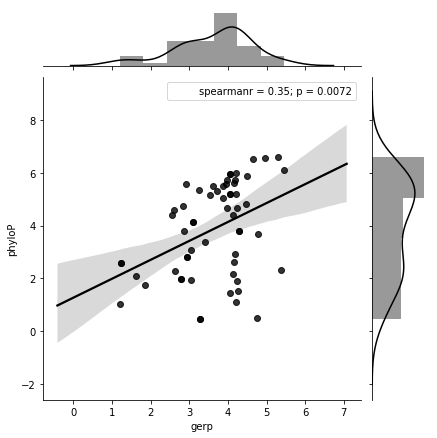

In [27]:
gerp = list(Variants["GERP"].values[:16]) + list(Variants["GERP"].values[18:])
phyloP = list(Variants["phyloP100way"].values[:16]) + list(Variants["phyloP100way"].values[18:])
j = sns.jointplot(x=gerp, y=phyloP, kind='reg', color="black")
j.annotate(spearmanr)
plt.xlabel("gerp")
plt.ylabel("phyloP")
plt.show()

In [28]:

def regGene(X, Y):
    regr = linear_model.LinearRegression(fit_intercept=False)
    X_train = np.array(X)
    X_train = np.reshape(X_train, (-1, 1))
    y_train = np.array(Y)
    y_train = np.reshape(y_train, (-1, 1))
    regr.fit(X_train, y_train)
    return regr
def plotGene(gene, regr, dat):
    X_train = np.array([[x[4]] for x in dat])
    y_train = np.array([x[3] for x in dat])
    y_pred = regr.predict(X_train)
    #print('Coefficients:', regr.coef_)
    R, P = scipy.stats.pearsonr([x[0] for x in X_train], y_train)
    plt.title("Gene:{}, R:{}, P:{}".format(gene, R,P))
    plt.xlim(0,3)
    plt.ylim(0, max(y_train+y_pred))
    plt.scatter(X_train, y_train,  color='black')
    plt.plot(np.append(X_train, [0]), np.append(y_pred, 0), color='blue', linewidth=3)
    plt.show()
    

In [29]:
#Variants = Variants[Variants["familyId"]!=13900]
gene2slope = {}
ALL_RelExp = np.array([])
ALL_Normed_IQD = np.array([])
Genes = list(set(Variants["effectGene"].values))
for gene in Genes:
    df = Variants[Variants["effectGene"]==gene]
    IQs = [max(0, (100-x)) for x in df["NVIQ"].values]
    #rel_exps = [x for x in df["Rel.exp.amean"].values] #Rel.exp.prenatal
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    regr = regGene(rel_exps, IQs)
    slope = regr.coef_[0]
    #if slope == 0:
    #    continue
    gene2slope[gene] = slope
    ALL_RelExp = np.append(ALL_RelExp, rel_exps)
    NormIQDs = np.array([x/slope for x in IQs])
    ALL_Normed_IQD = np.append(ALL_Normed_IQD, NormIQDs)

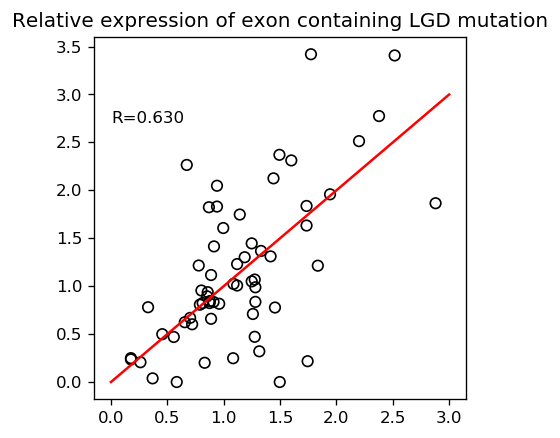

In [30]:
model = linear_model.LinearRegression(fit_intercept=False)
ALL_RelExp = ALL_RelExp.reshape(-1,1)
R, P = scipy.stats.pearsonr([x[0] for x in ALL_RelExp], ALL_Normed_IQD) 
plt.figure(figsize=(4,4), dpi=120)
plt.title("Relative expression of exon containing LGD mutation")
model.fit(ALL_RelExp, ALL_Normed_IQD)
plt.scatter(ALL_RelExp, ALL_Normed_IQD, s=40, facecolors='none', edgecolors='black')
plt.plot([0, 3], [0,model.predict([[3.0]])], color='red')
plt.text(0, 2.7, "R=%.3f"%(R))
plt.show()

In [31]:
def cdf(weights):
    total = sum(weights)
    result = []
    cumsum = 0
    for w in weights:
        cumsum += w
        result.append(cumsum / total)
    return result
def choice(population, weights):
    assert len(population) == len(weights)
    cdf_vals = cdf(weights)
    x = random.random()
    idx = bisect.bisect(cdf_vals, x)
    return population[idx]
def GetExonProb(exon_df):
    Total_length = sum(exon_df["cds length"].values)
    Probs = [float(x)/Total_length for x in exon_df["cds length"].values]
    return exon_df.index.values, Probs

68.0327868852459
(61, 38)
12752 CHD8 93.0 [27.83118645] 1.7445203292022404
13900 CHD8 27.0 [80.47699445] 0.672300850348769
11403 FOXP1 64.0 0 2.879538174647055
12952 MLL5 58.0 0 1.4159638594755717


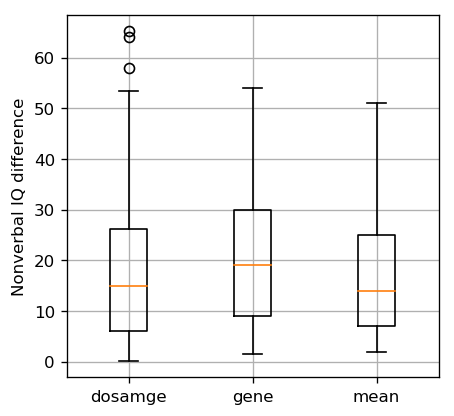

61 [-0.39238666] -0.44357324886562477 [0.03545825]
(61, 38)


In [70]:
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
SSE1, SSE2, SSE3 = 0,0,0
avg_IQ = np.mean(Variants["NVIQ"].values)
print(avg_IQ)
N = 0
ExcludeList = []
#Variants = Variants[Variants["familyId"]!=13900]
print(Variants.shape)
for i, row in Variants.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    #familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.prenatal"], row["NVIQ"]
    df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.gmean"].values]
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(familyId, gene, IQ, IQpre_dosage, ralexp)
    #    Variants.at[i, "Dosage"] = IQpre_dosage
    #    ExcludeList.append(familyId)
    #    continue
    Variants.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1
plt.figure(figsize=(4,4), dpi=120)
plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
plt.ylabel("Nonverbal IQ difference")
plt.grid(True)
plt.show()
print(N, (1-SSE1/SSE3),(1-SSE2/SSE3),(1-SSE1/SSE2))
print(Variants.shape)

In [71]:
def mapgender(row):
    if row["gender"] == "M": 
        return 1
    elif row["gender"] == "F":
        return 2
Variants["gender1"] = Variants.apply(lambda row:mapgender(row), axis=1)
Variants.head()

,familyId,vcfVariant,inChild,effectGene,effectType,gender,VIQ,NVIQ,ExonID,LastExon,...,GERP,Rel.exp.amean,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phastCons100way,GeneCount,Dosage,gender1
7,13545,20:49509094:G:GT,pM,ADNP,frame-shift,M,23.0,38.0,41150,N,...,2.928045,1.248356,1.290080,1.215442,1.325670,1.423534,0.732081,2,56.455400,1
8,12130,20:49510027:CTT:C,pF,ADNP,frame-shift,F,62.0,55.0,41150,N,...,2.928045,1.248356,1.290080,1.215442,1.325670,1.423534,0.732081,2,40.005218,2
14,12645,4:114232545:C:T,pM,ANK2,nonsense,M,94.0,84.0,125152,N,...,2.840792,0.996027,0.954498,0.898553,1.072089,-0.319194,0.891200,3,94.795355,1
15,14256,4:114251469:C:T,pM,ANK2,nonsense,M,105.0,98.0,125156,N,...,3.604094,0.831026,0.795717,0.722231,0.916289,-0.407787,0.877560,3,87.706348,1
16,13768,4:114277599:AG:A,pM,ANK2,frame-shift,M,100.0,94.0,125168,N,...,1.621037,0.720043,0.605800,0.919231,0.560651,0.648879,0.529323,3,92.136952,1


In [72]:
print(Variants.columns)

Index(['familyId', 'vcfVariant', 'inChild', 'effectGene', 'effectType',
       'gender', 'VIQ', 'NVIQ', 'ExonID', 'LastExon', 'GeneExp.amean',
       'GeneExp.gmean', 'ExonExp.amean', 'ExonExp.gmean',
       'GenePrenatalExp.amean', 'GenePrenatalExp.gmean',
       'ExonPrenatalExp.amean', 'ExonPrenatalExp.gmean',
       'GenePostnatalExp.amean', 'GenePostnatalExp.gmean',
       'ExonPostnatalExp.amean', 'ExonPostnatalExp.gmean', 'phyloP100way',
       'Functional', 'Age', 'KEY', 'DOM.TRUNC.FRAC', 'DOM.TRUNC', 'GERP',
       'Rel.exp.amean', 'Rel.exp.gmean', 'Rel.exp.prenatal',
       'Rel.exp.postnatal', 'Prenatal.Bias', 'phastCons100way', 'GeneCount',
       'Dosage', 'gender1'],
      dtype='object')


In [73]:
VariantsOut = Variants[['KEY','familyId', 'vcfVariant', 'inChild', 'effectGene', 'effectType',
       'gender', 'VIQ', 'NVIQ', 'ExonID', 'GeneExp.amean', 'ExonExp.amean',
       'GenePrenatalExp.amean', 'ExonPrenatalExp.amean', 'GenePostnatalExp.amean', 'ExonPostnatalExp.amean', 
       'Functional', 'DOM.TRUNC.FRAC','DOM.TRUNC', 'GERP', 'Rel.exp.amean','Rel.exp.gmean',
       'Rel.exp.prenatal', 'Rel.exp.postnatal', 'Prenatal.Bias',
       'phyloP100way', 'phastCons100way', 'gender1', 'Age', 'Dosage']]
VariantsOut.to_csv("unifiedmodel/features.jiayao.csv", index=False)

In [74]:
gerp = list(Variants["GERP"].values[:16]) + list(Variants["GERP"].values[18:])
tmpIQs = list(Variants["NVIQ"].values[:16]) + list(Variants["NVIQ"].values[18:])
r, p = pearsonr(np.array(gerp), np.array(tmpIQs))
print("GERP", r, p)

GERP -0.22438453219477916 0.08754090175508167


In [75]:
def SSE(List1, List2):
    return sum([(x-y)**2 for x,y in zip(List1, List2)])
def PredErrMean(List1, List2):
    return np.mean([abs(x-y) for x,y in zip(List1, List2)])
def PredErrMedian(List1, List2):
    return np.median([abs(x-y) for x,y in zip(List1, List2)])

In [76]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.csv")
Jiayao_features.head(2)

,KEY,familyId,vcfVariant,inChild,effectGene,effectType,gender,VIQ,NVIQ,ExonID,...,Rel.exp.amean,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phyloP100way,phastCons100way,gender1,Age,Dosage
0,13545-20:49509095,13545,20:49509094:G:GT,pM,ADNP,frame-shift,M,23.0,38.0,41150,...,1.248356,1.29008,1.215442,1.32567,1.423534,2.813101,0.732081,1,61.0,56.455400
1,12130-20:49510028,12130,20:49510027:CTT:C,pF,ADNP,frame-shift,F,62.0,55.0,41150,...,1.248356,1.29008,1.215442,1.32567,1.423534,2.813101,0.732081,2,101.0,40.005218


In [77]:
ExcludeList = ["13398-1:151377904", "13627-1:151378489", "13664-1:202698172", "13447-6:157527665", 
               "12323-9:96439930", "13545-20:49509095", "12130-20:49510028", "12764-2:183791570", "13735-21:41414331"]
#ExcludeList = []
Jiayao_features = Jiayao_features[~Jiayao_features["KEY"].isin(ExcludeList)]
GeneCount = Jiayao_features.groupby("effectGene")["effectGene"].count()
Jiayao_features["GeneCount"] = Jiayao_features.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Jiayao_features = Jiayao_features[Jiayao_features["GeneCount"]>=2]
print(Jiayao_features.shape)

(52, 31)


68.25
12752-14:21861377 CHD8 93.0 [27.87568178] 1.7445203292022404
13900-14:21895990 CHD8 27.0 [80.26547977] 0.672300850348769
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12952-7:104748101 MLL5 58.0 0 1.4159638594755717


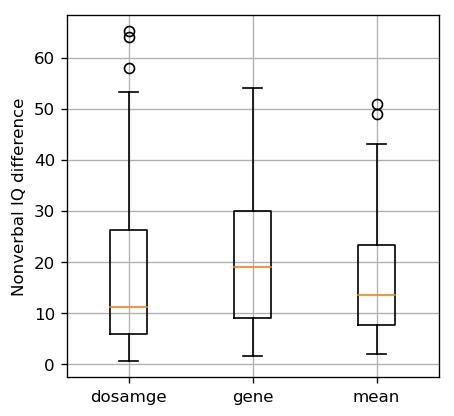

(52, 31)
[31984.93948202] 32493.55555555556 22355.0
[18.35245831] 20.98076923076923 16.75


In [78]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
SSE1, SSE2, SSE3 = [], [], []
avg_IQ = np.mean(Jiayao_features["NVIQ"].values)
print(avg_IQ)
N = 0
for i, row in Jiayao_features.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
        #Jiayao_features.at[i, "Dosage"] = IQpre_dosage
        #ExcludeList.append(familyId)
        #continue
    Jiayao_features.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    SSE1.append(abs(IQ - IQpre_dosage) )
    SSE2.append(abs(IQ - IQpre_gene) )
    SSE3.append(abs(IQ - 70) )
plt.figure(figsize=(4,4), dpi=120)
plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
plt.ylabel("Nonverbal IQ difference")
plt.grid(True)
plt.show()
print(Jiayao_features.shape)
SSE_dosage = sum([x**2 for x in SSE1])
SSE_Gene = sum([x**2 for x in SSE2])
SSE_Mean = sum([x**2 for x in SSE3])
print(SSE_dosage, SSE_Gene, SSE_Mean)
print(np.mean(SSE1), np.mean(SSE2), np.mean(SSE3))

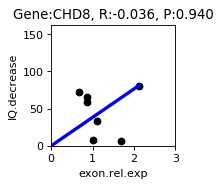

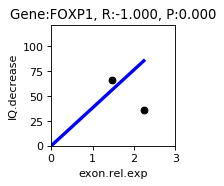

In [79]:
def plotGene(gene, dat):
    dat = dat[dat["effectGene"]==gene]
    X_train = np.array(dat["Rel.exp.gmean"].values)
    IQs = dat["NVIQ"].values
    y_train = np.array([max(0, (100-x)) for x in IQs])
    regr = regGene(rel_exps, IQDiffs)
    y_pred = regr.predict(np.reshape(X_train, (-1,1)))
    R, P = scipy.stats.pearsonr(X_train, y_train)
    plt.figure(figsize=(2,2), dpi=80)
    plt.title("Gene:%s, R:%.3f, P:%.3f"%(gene, R,P))
    plt.xlim(0,3)
    plt.ylim(0, max(y_train[0]+y_pred[0]))
    plt.scatter(X_train, y_train,  color='black')
    plt.plot(np.append(X_train, [0]), np.append(y_pred, 0), color='blue', linewidth=3)
    plt.xlabel("exon.rel.exp")
    plt.ylabel("IQ.decrease")
    plt.show()
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
plotGene("CHD8", Jiayao_features)
plotGene("FOXP1", Jiayao_features)

In [80]:
GLMs = []
Jiayao_features = Jiayao_features[~Jiayao_features["familyId"].isin(ExcludeList)]
print(Jiayao_features.shape)
print("%20s\t%8s\t%8s\t%8s\t%8s\t%8s"%("feature", "spearmanr", "P_corr", "R2_gene", "R2_mean", "Mean.Err"))
X = np.array(Jiayao_features["Dosage"].values)

X = np.reshape(X, (-1,1))
#print(X.shape[0])
#const = np.reshape(  np.ones(X.shape[0]),(-1,1))
#X = np.hstack((const, X))
Y = np.reshape(np.array(Jiayao_features["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit()
GLMs.append(res)
pred = res.predict(X)
r, p = spearmanr(np.array(Jiayao_features["Dosage"]), np.array(Jiayao_features["NVIQ"]))
R2_gene = 1- SSE(pred, Y)/SSE_Gene
R2_mean = 1- SSE(pred, Y)/SSE_Mean
print("%20s\t%8.3f\t%8.2e\t%8.4f\t%8.4f\t%8.4f"%("Dosage", r, p, R2_gene, R2_mean, PredErrMean(pred, Y)))
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
                "phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(Jiayao_features[feature].values), np.array(Jiayao_features["NVIQ"].values))
    x = np.array(Jiayao_features[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
    R2_gene = 1- SSE(pred, Y)/SSE_Gene
    R2_mean = 1- SSE(pred, Y)/SSE_Mean
    print("%20s\t%8.3f\t%8.2e\t%8.4f\t%8.4f\t%8.4f"%(feature, r, p, R2_gene, R2_mean, PredErrMean(pred, Y)))
print(res.summary())

(52, 31)
             feature	spearmanr	  P_corr	 R2_gene	 R2_mean	Mean.Err
              Dosage	   0.290	3.73e-02	  0.0174	 -0.4283	 19.1244
    Rel.exp.prenatal	  -0.273	5.04e-02	  0.1744	 -0.2000	 18.6811
   Rel.exp.postnatal	  -0.121	3.94e-01	  0.1745	 -0.2000	 18.6895
        phyloP100way	  -0.304	2.86e-02	  0.1775	 -0.1956	 18.7080
          Functional	  -0.097	4.92e-01	  0.1811	 -0.1903	 18.6053
           DOM.TRUNC	   0.078	5.82e-01	  0.1958	 -0.1689	 18.4799
                 Age	  -0.112	4.31e-01	  0.1958	 -0.1689	 18.4662
             gender1	  -0.143	3.12e-01	  0.2182	 -0.1363	 18.6976
       Prenatal.Bias	  -0.150	2.88e-01	  0.2196	 -0.1343	 18.7068
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   52
Model:                            GLM   Df Residuals:                       43
Model Family:                Gaussian   Df Model:                            8
Link Function:

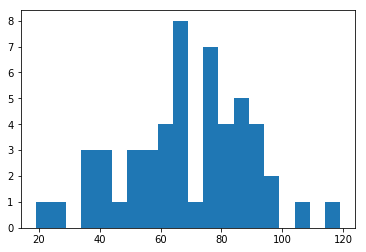

23.73076923076923


In [43]:
plt.hist(Jiayao_features["NVIQ"], bins=20)
plt.show()
import itertools
def con(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = range(r)
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)
        
test = []
for x,y in (list(itertools.combinations(Jiayao_features["NVIQ"].values, 2))):
    test.append(abs(x-y))
print(np.mean(test))

In [81]:
Jiayao_features.to_csv("unifiedmodel/features.jiayao.52.csv", index=False)

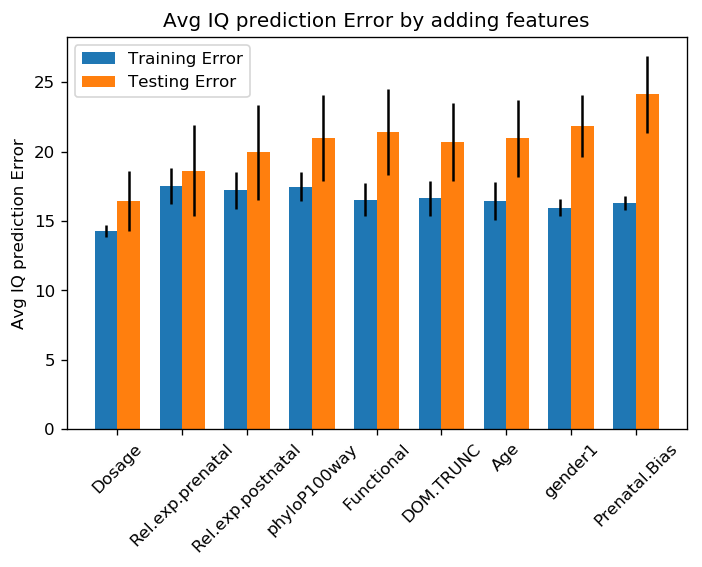

In [111]:
def CrossVal(df, Splits, Xlabels, Ylabel="NVIQ", Fold=5):
    Scores_Train, Scores_Test = [], []
    for i in range(Fold):
        heldout = Splits[i]
        TestingDat = df.loc[heldout[0]:heldout[1],:]
        TrainingDat = df[~df["KEY"].isin(TestingDat["KEY"].values)]
        assert len(Xlabels) >= 1
        X_train = np.reshape(np.array(TrainingDat[Xlabels[0]].values), (-1,1))
        #const_train = np.reshape(np.ones(X_train.shape[0]),(-1,1))
        #X_train = np.hstack((const_train, X_train))
        X_test = np.reshape(np.array(TestingDat[Xlabels[0]].values), (-1,1))
        #const_test = np.reshape(np.ones(X_test.shape[0]),(-1,1))
        #X_test = np.hstack((const_test, X_test))
        for i in range(1, len(Xlabels)):
            x_train = np.reshape(np.array(TrainingDat[Xlabels[i]].values), (-1,1))
            X_train = np.hstack((X_train, x_train))
            x_test = np.reshape(np.array(TestingDat[Xlabels[i]].values), (-1,1))
            X_test = np.hstack((X_test, x_test))
        Y_train = np.reshape(np.array(TrainingDat["NVIQ"].values), (-1, 1))
        Y_test = np.reshape(np.array(TestingDat["NVIQ"].values), (-1, 1))
        glm = sm.GLM(Y_train, X_train, family=sm.families.Gaussian())
        res = glm.fit(method="newton")
        pred_train = res.predict(X_train)
        pred_test = res.predict(X_test)
        #Scores_Train.append(PredErrMean(pred_train, Y_train))
        #Scores_Test.append(PredErrMean(pred_test, Y_test))
        Scores_Train.append(PredErrMedian(pred_train, Y_train))
        Scores_Test.append(PredErrMedian(pred_test, Y_test))
    return Scores_Train, Scores_Test
    

Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
Splits = [(0,9), (10,19), (20,29), (30, 39), (40, 52)]
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
Addfeatures = []
Fold = 5
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures)
    TrainingErr.append(np.mean(Scores_Train))
    TrainingErrConf.append(np.std(Scores_Train)  / math.sqrt(Fold))
    TestingErr.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

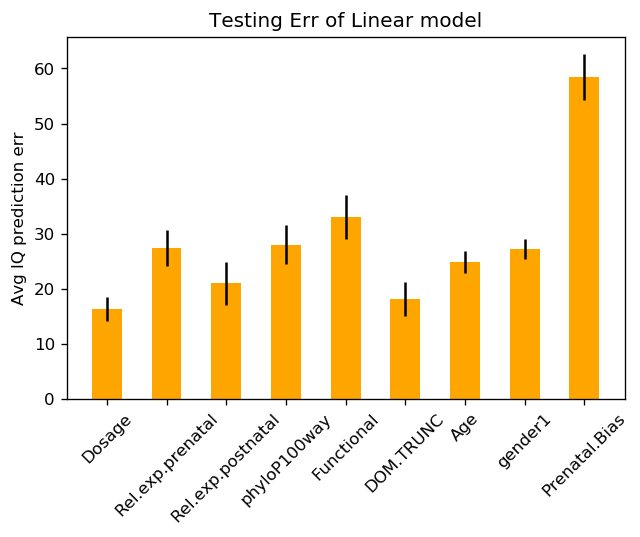

In [112]:
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
#features = reversed(features)
Addfeatures = []
TestingErrs = []
TestingErrConf = []
for feature in features:
    #Addfeatures.append(feature)
    Addfeatures = [feature]
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures)
    TestingErrs.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
    #print(", ".join(Addfeatures))
    #print("Training Err: %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err: %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
x_pos = np.arange(len(features))
fig, ax = plt.subplots(dpi=120)
plt.title("Testing Err of Linear model")
ax.bar(x_pos, TestingErrs, 0.5 ,yerr=TestingErrConf, color="orange")
ax.set_xticks(x_pos)
ax.set_xticklabels(features)
plt.ylabel("Avg IQ prediction err")
plt.xticks(rotation=45)
plt.show()

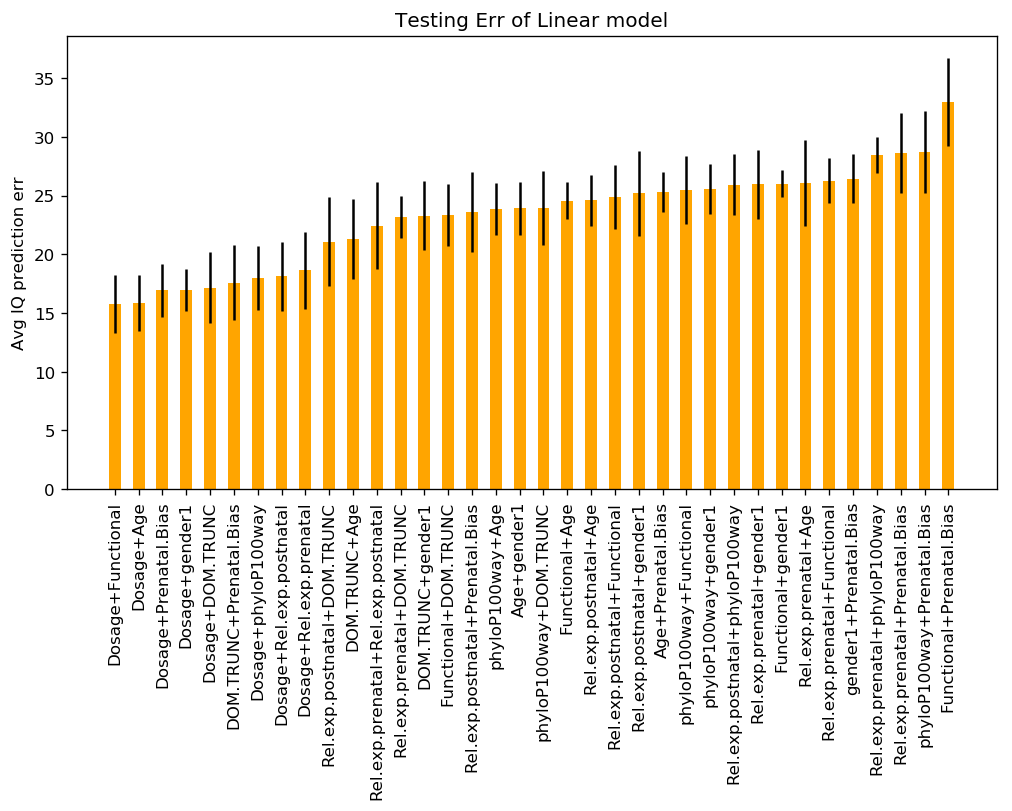

In [113]:
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
#features = reversed(features)
Addfeatures = []
TestingErrs = []
TestingErrConf = []
for feature1, feature2 in itertools.combinations(features, 2):
    #Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, [feature1, feature2])
    Addfeatures.append([feature1, feature2])
    TestingErrs.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
tmp = list(zip(Addfeatures, TestingErrs, TestingErrConf))
tmp = sorted(tmp, key=lambda x:x[1])
Addfeatures = [x for x,y,z in tmp]
TestingErrs = [y for x,y,z in tmp]
TestingErrConf = [z for x,y,z in tmp]
x_pos = np.arange(len(Addfeatures))
fig, ax = plt.subplots(figsize=(10,5), dpi=120)
plt.title("Testing Err of Linear model")
ax.bar(x_pos, TestingErrs, 0.5 ,yerr=TestingErrConf, color="orange")
ax.set_xticks(x_pos)
ax.set_xticklabels(["%s+%s"%(x,y) for x,y in Addfeatures])
plt.ylabel("Avg IQ prediction err")
plt.xticks(rotation=90)
plt.show()

[(0.0, 7.0), (8.0, 15.0), (16.0, 23.0), (24.0, 31.0), (32.0, 39)]


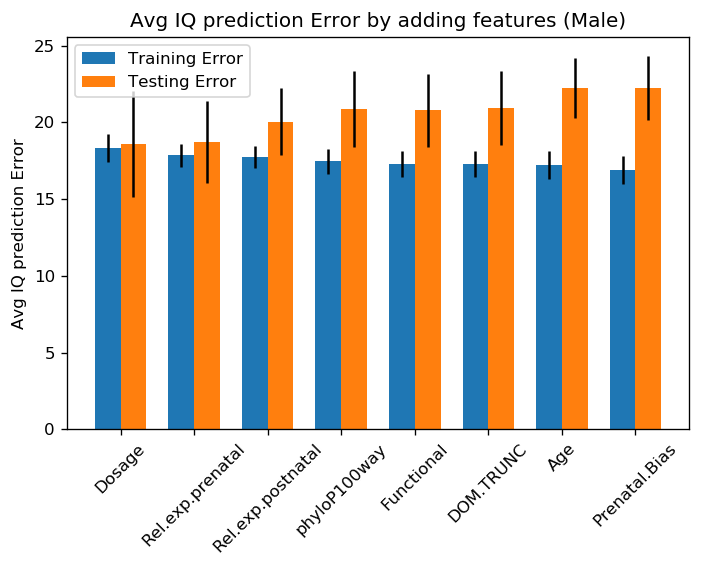

In [85]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["gender"]=='M']
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
Len = Jiayao_features.shape[0]
Fold = 5
step = Len/Fold
Splits = [(i*step,i*step+step-1) for i in range(Fold-1)] + [((Fold-1)*step, Len-1)]
print(Splits)
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "Prenatal.Bias"]
Addfeatures = []
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures)
    TrainingErr.append(np.mean(Scores_Train))
    TrainingErrConf.append(np.std(Scores_Train)  / math.sqrt(Fold))
    TestingErr.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features (Male)')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

[(0, 2), (3, 5), (6, 8), (9, 11)]


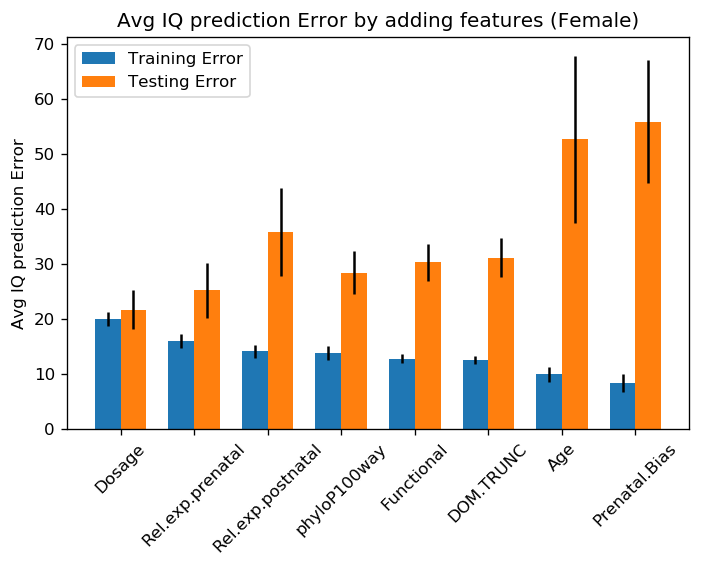

In [86]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["gender"]=='F']
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
Len = Jiayao_features.shape[0]
Fold = 4
step = int(Len/Fold)
Splits = [(i*step,i*step+step-1) for i in range(Fold-1)] + [((Fold-1)*step, Len-1)]
print(Splits)
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "Prenatal.Bias"]
Addfeatures = []
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    try:
        Addfeatures.append(feature)
        Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures, Fold=Fold)
        TrainingErr.append(np.mean(Scores_Train))
        TrainingErrConf.append(np.std(Scores_Train)  / math.sqrt(Fold))
        TestingErr.append(np.mean(Scores_Test))
        TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
    except:
        TrainingErr.append(0)
        TrainingErrConf.append(0)
        TestingErr.append(0)
        TestingErrConf.append(0)
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features (Female)')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

[(0, 2), (3, 5), (6, 8), (9, 11), (12, 15)]


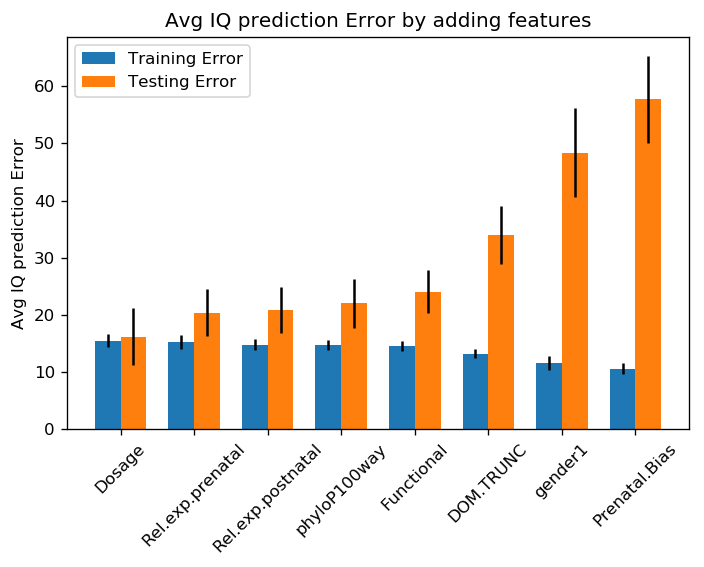

In [87]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["Age"]>=144]
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
Len = Jiayao_features.shape[0]
Fold = 5
step = int(Len/Fold)
Splits = [(i*step,i*step+step-1) for i in range(Fold-1)] + [((Fold-1)*step, Len-1)]
print(Splits)
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "gender1", "Prenatal.Bias"]
Addfeatures = []
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures)
    TrainingErr.append(np.mean(Scores_Train))
    TrainingErrConf.append(np.std(Scores_Train) / math.sqrt(Fold))
    TestingErr.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test) / math.sqrt(Fold))
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

[(0, 6), (7, 13), (14, 20), (21, 27), (28, 35)]


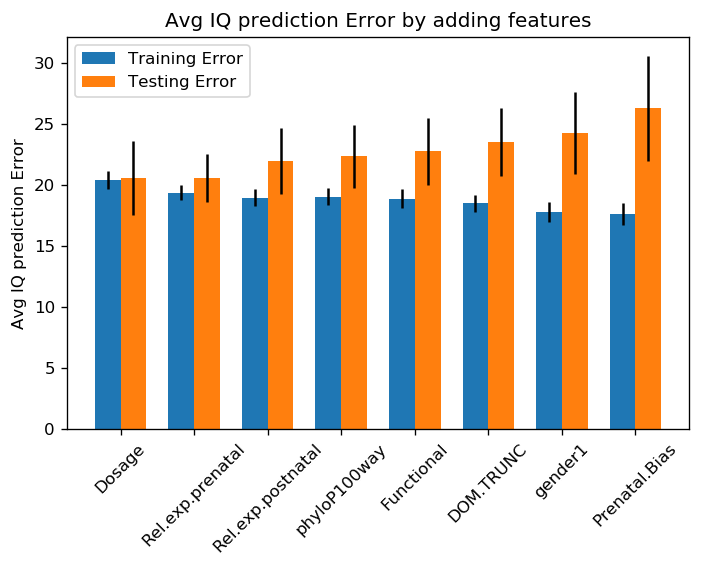

In [88]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["Age"]<144]
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
Len = Jiayao_features.shape[0]
Fold = 5
step = int(Len/Fold)
Splits = [(i*step,i*step+step-1) for i in range(Fold-1)] + [((Fold-1)*step, Len-1)]
print(Splits)
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "gender1", "Prenatal.Bias"]
Addfeatures = []
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures)
    TrainingErr.append(np.mean(Scores_Train))
    TrainingErrConf.append(np.std(Scores_Train) / math.sqrt(Fold))
    TestingErr.append(np.mean(Scores_Test))
    TestingErrConf.append(np.std(Scores_Test) / math.sqrt(Fold))
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [93]:
def DosageModel(df):
    GeneCount = df.groupby("effectGene")["effectGene"].count()
    df["GeneCount"] = df.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
    df = df[df["GeneCount"]>=2].copy()
    IQ_diff_dosage, IQ_diff_gene, IQ_diff_mean = [], [], []
    avg_IQ = np.mean(df["NVIQ"].values)
    for i, row in df.iterrows():
        familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
        tmp = df[(df["effectGene"]==gene) & (df["familyId"]!=familyId)]
        IQs = tmp["NVIQ"].values
        IQDiffs = [max(0, (100-x)) for x in IQs]
        rel_exps = list(tmp["Rel.exp.amean"].values)
        regr = regGene(rel_exps, IQDiffs)
        slope = regr.coef_[0]
        IQpre_dosage = max(0, (100 - slope * ralexp))
        IQpre_gene = np.mean(IQs)
        if abs(IQ - IQpre_dosage) > 50:
            print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
            #Jiayao_features.at[i, "Dosage"] = IQpre_dosage
            #ExcludeList.append(familyId)
            #continue
        df.loc[i, "Dosage"] = IQpre_dosage
        IQ_diff_dosage.append(abs(IQ - IQpre_dosage))
        IQ_diff_gene.append(abs(IQ - IQpre_gene))
        IQ_diff_mean.append(abs(IQ - avg_IQ))
    plt.figure(figsize=(4,4), dpi=120)
    plt.boxplot([IQ_diff_dosage, IQ_diff_gene, IQ_diff_mean], labels = ["dosamge", "gene", "mean"])
    plt.ylabel("Nonverbal IQ difference")
    plt.grid(True)
    plt.show()
    print("Mean:\tDosage:%.3f\tGene:%.3f\tMean:%.3f"%(np.mean(IQ_diff_dosage), np.mean(IQ_diff_gene), np.mean(IQ_diff_mean)))
    print("Median:\tDosage:%.3f\tGene:%.3f\tMean:%.3f"%(np.median(IQ_diff_dosage), np.median(IQ_diff_gene), np.median(IQ_diff_mean)))
    return df

12752-14:21861377 CHD8 93.0 [27.87568178] 1.7445203292022404
13900-14:21895990 CHD8 27.0 [80.26547977] 0.672300850348769
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12952-7:104748101 MLL5 58.0 0 1.4159638594755717


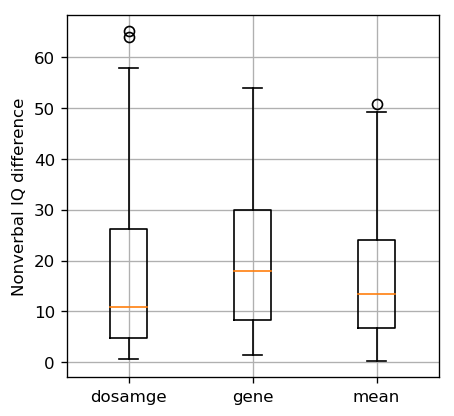

Mean:	Dosage:18.049	Gene:20.192	Mean:16.683
Median:	Dosage:10.915	Gene:18.000	Mean:13.500
52
41
9.118273195538508
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   41
Model:                            GLM   Df Residuals:                       31
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          188.31
Method:                          IRLS   Log-Likelihood:                -159.83
Date:                Wed, 19 Jun 2019   Deviance:                       5837.6
Time:                        18:47:21   Pearson chi2:                 5.84e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.

In [94]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
df = DosageModel(Jiayao_features)
print(df.shape[0])
df = df[abs(df["Dosage"] - df["NVIQ"]) < 30]
print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
GLMs.append(res)
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
                "phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
print(PredErrMean(pred, Y))
print(res.summary())

13256-21:38877892 DYRK1A 85.0 [14.85585804] 1.2752138377276143


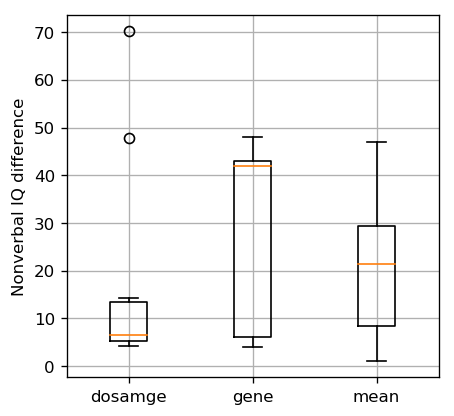

Mean:	Dosage:17.656	Gene:28.600	Mean:20.140
Median:	Dosage:6.507	Gene:42.000	Mean:21.500
10
10
7.735343148060011
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   10
Model:                            GLM   Df Residuals:                        3
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          448.03
Method:                          IRLS   Log-Likelihood:                -38.694
Date:                Wed, 19 Jun 2019   Deviance:                       1344.1
Time:                        18:55:37   Pearson chi2:                 1.34e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        216.0

In [105]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["Age"]>=144]
df = DosageModel(Jiayao_features)
print(df.shape[0])
#df = df[abs(df["Dosage"] - df["NVIQ"]) < 30]
print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
GLMs.append(res)
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
               "phyloP100way", "Functional", "DOM.TRUNC"]:#, #"gender1", "Prenatal.Bias"]:
#    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
print(PredErrMedian(pred, Y))
print(res.summary())

11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12952-7:104748101 MLL5 58.0 0 1.4159638594755717


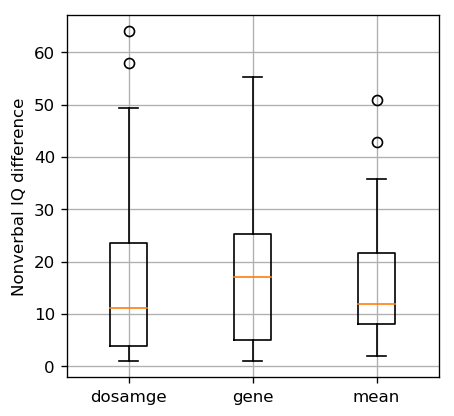

Mean:	Dosage:16.516	Gene:17.586	Mean:16.220
Median:	Dosage:11.065	Gene:17.000	Mean:11.857
35
13.637044655024255
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       26
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          386.17
Method:                          IRLS   Log-Likelihood:                -148.70
Date:                Wed, 19 Jun 2019   Deviance:                       10040.
Time:                        19:01:35   Pearson chi2:                 1.00e+04
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.24

/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [116]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["gender"]=='M']
df = DosageModel(Jiayao_features)
print(df.shape[0])
#df = df[abs(df["Dosage"] - df["NVIQ"]) < 30]
#print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
GLMs.append(res)
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
                "phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
print(PredErrMean(pred, Y))
print(res.summary())

In [57]:
Jon_features = pd.read_csv("unifiedmodel/model-features.csv")
Jon_features = Jon_features[~Jon_features["KEY"].isin(ExcludeList)]
Jon_features.head()

,KEY,ENTREZ,NVIQ,PRED,AGE,GEND,DOM.TRUNC,DOM.TRUNC.FRAC,PRENATAL,POSTNATAL,DEV.BIAS,CONSERV,FUNC
0,12645-4:114232545,287,84,4.928226,51.0,M,True,0.40,0.871835,1.098588,-0.333523,2.840792,NEUR
1,13768-4:114277600,287,94,7.530656,176.0,M,True,0.20,0.894915,0.575636,0.636595,1.621037,NEUR
2,14256-4:114251469,287,98,11.144313,183.0,M,True,0.40,0.699788,0.939402,-0.424824,3.604094,NEUR
3,13614-15:93563244,1106,81,13.164656,113.0,M,False,0.00,0.209119,0.150609,0.473517,3.270302,DEV
4,13618-15:93524061,1106,49,73.382222,159.0,F,True,0.25,0.813168,0.610889,0.412643,4.175000,DEV


In [58]:
def mapgender(row):
    if row["GEND"] == "M": 
        return 1
    elif row["GEND"] == "F":
        return 2
def mapfunc(row):
    if row["FUNC"] == "NEUR": 
        return 1
    elif row["FUNC"] == "DEV":
        return 2
    else:
        return 0
def mapdomain(row):
    if row["DOM.TRUNC"] == True: 
        return 1
    elif row["DOM.TRUNC"] == False:
        return 2
Jon_features["GEND2"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
Jon_features["FUNC2"] = Jon_features.apply(lambda row:mapfunc(row), axis=1)
Jon_features["DOM.TRUNC2"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
#Jon_features["effectGene"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
Jon_features.head()

,KEY,ENTREZ,NVIQ,PRED,AGE,GEND,DOM.TRUNC,DOM.TRUNC.FRAC,PRENATAL,POSTNATAL,DEV.BIAS,CONSERV,FUNC,GEND2,FUNC2,DOM.TRUNC2
0,12645-4:114232545,287,84,4.928226,51.0,M,True,0.40,0.871835,1.098588,-0.333523,2.840792,NEUR,1,1,1
1,13768-4:114277600,287,94,7.530656,176.0,M,True,0.20,0.894915,0.575636,0.636595,1.621037,NEUR,1,1,1
2,14256-4:114251469,287,98,11.144313,183.0,M,True,0.40,0.699788,0.939402,-0.424824,3.604094,NEUR,1,1,1
3,13614-15:93563244,1106,81,13.164656,113.0,M,False,0.00,0.209119,0.150609,0.473517,3.270302,DEV,1,2,1
4,13618-15:93524061,1106,49,73.382222,159.0,F,True,0.25,0.813168,0.610889,0.412643,4.175000,DEV,2,2,2


In [ ]:
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
SSE1, SSE2, SSE3 = 0,0,0
avg_IQ = np.mean(Jon_features["NVIQ"].values)
print(avg_IQ)
N = 0
ExcludeList = []
print(Jon_features.shape)
for i, row in Jon_features.iterrows():
    familyId, gene, pred, IQ = row["KEY"], row["ENTREZ"], row["PRED"], row["NVIQ"]
    df = Jon_features[(Jon_features["ENTREZ"]==gene) & (Jon_features["KEY"]!=familyId)]
    if len(df["NVIQ"].values)<1:
        #print(gene)
        continue
    if abs(IQ - IQpre_dosage) > 50:
        print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
        #Variants.at[i, "Dosage"] = IQpre_dosage
        #ExcludeList.append(familyId)
        #continue
    IQpre_gene = np.mean(df["NVIQ"].values)
    IQ_diff1.append(abs(IQ - (100-pred)))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1
plt.figure(figsize=(4,4), dpi=120)
plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
plt.ylabel("Nonverbal IQ difference")
plt.grid(True)
plt.show()
print(SSE1, SSE2, SSE3)
print(N, (1-SSE1/SSE3),(1-SSE2/SSE3),(1-SSE1/SSE2))

In [ ]:
print("%20s\t%8s\t%8s\t%8s\t%.8s"%("feature", "spearmanr", "P_corr", "R2_gene", "R2_mean"))
X = np.array(Jon_features["PRED"].values)
X = np.reshape(X, (-1,1))
Y = np.reshape(np.array(Jon_features["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit()
pred = res.predict(X)
r, p = spearmanr(np.array(Jon_features["PRED"]), np.array(Jon_features["NVIQ"]))
R2_gene = 1- SSE(pred, Y)/SSE2
R2_mean = 1- SSE(pred, Y)/SSE3
print("%20s\t%8.3f\t%8.2e\t%8.4f\t%.8f"%("PRED", r, p, R2_gene, R2_mean))
for feature in ["PRENATAL","POSTNATAL","DEV.BIAS","CONSERV","GEND2","FUNC2","DOM.TRUNC2"]:
    r, p = spearmanr(np.array(Jon_features[feature].values), np.array(Jon_features["NVIQ"].values))
    x = np.array(Jon_features[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    pred = res.predict(X)
    R2_gene = 1- SSE(pred, Y)/SSE2
    R2_mean = 1- SSE(pred, Y)/SSE3
    print("%20s\t%8.3f\t%8.2e\t%8.4f\t%.8f"%(feature, r, p, R2_gene, R2_mean))

In [ ]:
Jon_keys = set(Jon_features["KEY"].values)
Jiayao_keys = set(Jiayao_features["KEY"].values)
print(Jon_keys.difference(Jiayao_keys))
print(Jiayao_keys.difference(Jon_keys))
common_keys = Jon_keys.intersection(Jiayao_keys)
print(len(common_keys))

In [ ]:
Jiayao_features_common = Jiayao_features[Jiayao_features["KEY"].isin(common_keys)]
for row in Jiayao_features_common.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    #familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.prenatal"], row["NVIQ"]
    df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(familyId, IQ, IQpre_dosage, ralexp)
        Variants.at[i, "Dosage"] = IQpre_dosage
        ExcludeList.append(familyId)
        continue
    Variants.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - avg_IQ))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1

In [ ]:
Jon_features["famid"] = Jon_features.apply(lambda row:int(row["KEY"].split("-")[0]), axis=1)
Jon_features[Jon_features["famid"].isin(ExcludeList)]

In [ ]:
Jiayao_features[Jiayao_features["familyId"].isin(ExcludeList)]

In [ ]:
print(ExcludeList)

In [ ]:
PredCor = []
Jiayao_pre = []
Jon_pre = []
for key in common_keys:
    Jiayao_pre.append(100-Jiayao_features[Jiayao_features["KEY"]==key]["Dosage"].values[0])
    Jon_pre.append(Jon_features[Jon_features["KEY"]==key]["PRED"].values[0])
    
j = sns.jointplot(x=Jiayao_pre, y=Jon_pre, kind='reg', color="black")
j.annotate(pearsonr)
plt.xlabel("Jiayao")
plt.ylabel("Jon")
plt.show()